<a href="https://colab.research.google.com/github/MoeinDSP/NLP_Projects/blob/main/Text%20Clustering/04_Text_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Clustering

In this session we will learn how to cluster text documents. Clustering is an unsupervised learning technique that is useful when we don't know what categories exist in the data.

Parts of the following tutorial are based on this scikit-learn page: [link](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html)

**Optional for Colab users**

Before starting, we can set up the connection with the Google Dive storage, to keep there our documents.
Just execute the following passages:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make sure that the variable path contains the correct sequence of folders separate by a `'/'` to get to your lecture files

In [2]:
import os

path = '/content/drive/MyDrive/Practical_04__Clustering-Text'

os.chdir(f'{path}')
os.getcwd()

'/content/drive/MyDrive/Practical_04__Clustering-Text'

In [3]:
os.listdir()

['.DS_Store', '04 - Text Clustering.ipynb', '.ipynb_checkpoints', 'docs']

## Data prepration

As usual we start from data prepration.

### Data loading

First thing we need to do is load a set of documents that we can cluster.

We will use the *News Category Dataset*, openly available on Kaggle ([data set link](https://www.kaggle.com/datasets/rmisra/news-category-dataset)). The dataset contains more than 200,000 news headlines from 2012 to 2022 from HuffPost.

The data set is available as a single JSON file, we can load it using Python's built in json package.

In [4]:
import json

with open('docs/News_Category_Dataset_v3.json') as f:
    dataset = [json.loads(line) for line in f]

Since the data set consists of a large set of documents it may be useful for the scope of this tutorial to subsample it

In [5]:
# Skip this cell if you want to use the entire data set
dataset = dataset[::5] #we gonna take one news out of every 5

Let's check the size of the data set:

In [6]:
print(f"No. of documents: {len(dataset)}")

No. of documents: 41906


Each document is composed of an headline and a short description of the news.

In this data set documents are organised into Python dictionaries to store some additional information. Here is an example:

In [7]:
for key, value in dataset[0].items():
    print(f"{key}: {value}")

link: https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9
headline: Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters
category: U.S. NEWS
short_description: Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
authors: Carla K. Johnson, AP
date: 2022-09-23


Each document is assocated with one of out of 42 different categories:

In [8]:
print(f"Label for the first example is: {dataset[0]['category']}")
print('\nCategories:')
{sample['category'] for sample in dataset}

Label for the first example is: U.S. NEWS

Categories:


{'ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'U.S. NEWS',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST'}

### Data preprocessing

Before moving to clustering and topic modelling we need to preprocess our data set to extract the documents and the labels inside.

We are going to create our collection of documents combining the headline and the short description of a sample in our data set

In [9]:
documents = [f"{sample['headline']}\n\n{sample['short_description']}" for sample in dataset]

Now the first document looks like this:

In [10]:
print(documents[0])

Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters

Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.


Apart from the documents, we also need to retain the associated labels. Even though this is an unsupervised learning task, it would be useful to keep the labels for the assessment of the clustering results (more on this later).

In [11]:
labels = [sample['category'] for sample in dataset]

In [12]:
print(labels[0])

U.S. NEWS


Let's give a look at the labels distribution, first we need to count the occurrences of each label.

To do so we can use Python's `Counter`


In [13]:
from collections import Counter

label_count = Counter(labels)
label_count

Counter({'U.S. NEWS': 276,
         'WORLD NEWS': 671,
         'ENTERTAINMENT': 3355,
         'POLITICS': 7139,
         'ENVIRONMENT': 302,
         'CULTURE & ARTS': 215,
         'TECH': 432,
         'SCIENCE': 441,
         'WELLNESS': 3542,
         'SPORTS': 1043,
         'STYLE & BEAUTY': 2004,
         'WEIRD NEWS': 581,
         'FOOD & DRINK': 1275,
         'QUEER VOICES': 1238,
         'CRIME': 681,
         'PARENTING': 1761,
         'MEDIA': 604,
         'BLACK VOICES': 907,
         'COMEDY': 1158,
         'WOMEN': 680,
         'BUSINESS': 1143,
         'TRAVEL': 2028,
         'HOME & LIVING': 851,
         'EDUCATION': 206,
         'LATINO VOICES': 253,
         'MONEY': 356,
         'IMPACT': 697,
         'RELIGION': 519,
         'ARTS & CULTURE': 275,
         'STYLE': 491,
         'GREEN': 511,
         'HEALTHY LIVING': 1325,
         'PARENTS': 776,
         'TASTE': 423,
         'COLLEGE': 240,
         'THE WORLDPOST': 716,
         'GOOD NEWS': 

Now we can visualise the counts of each label

In [14]:
label_count.keys()

dict_keys(['U.S. NEWS', 'WORLD NEWS', 'ENTERTAINMENT', 'POLITICS', 'ENVIRONMENT', 'CULTURE & ARTS', 'TECH', 'SCIENCE', 'WELLNESS', 'SPORTS', 'STYLE & BEAUTY', 'WEIRD NEWS', 'FOOD & DRINK', 'QUEER VOICES', 'CRIME', 'PARENTING', 'MEDIA', 'BLACK VOICES', 'COMEDY', 'WOMEN', 'BUSINESS', 'TRAVEL', 'HOME & LIVING', 'EDUCATION', 'LATINO VOICES', 'MONEY', 'IMPACT', 'RELIGION', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'HEALTHY LIVING', 'PARENTS', 'TASTE', 'COLLEGE', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'ARTS', 'FIFTY', 'DIVORCE', 'WEDDINGS'])

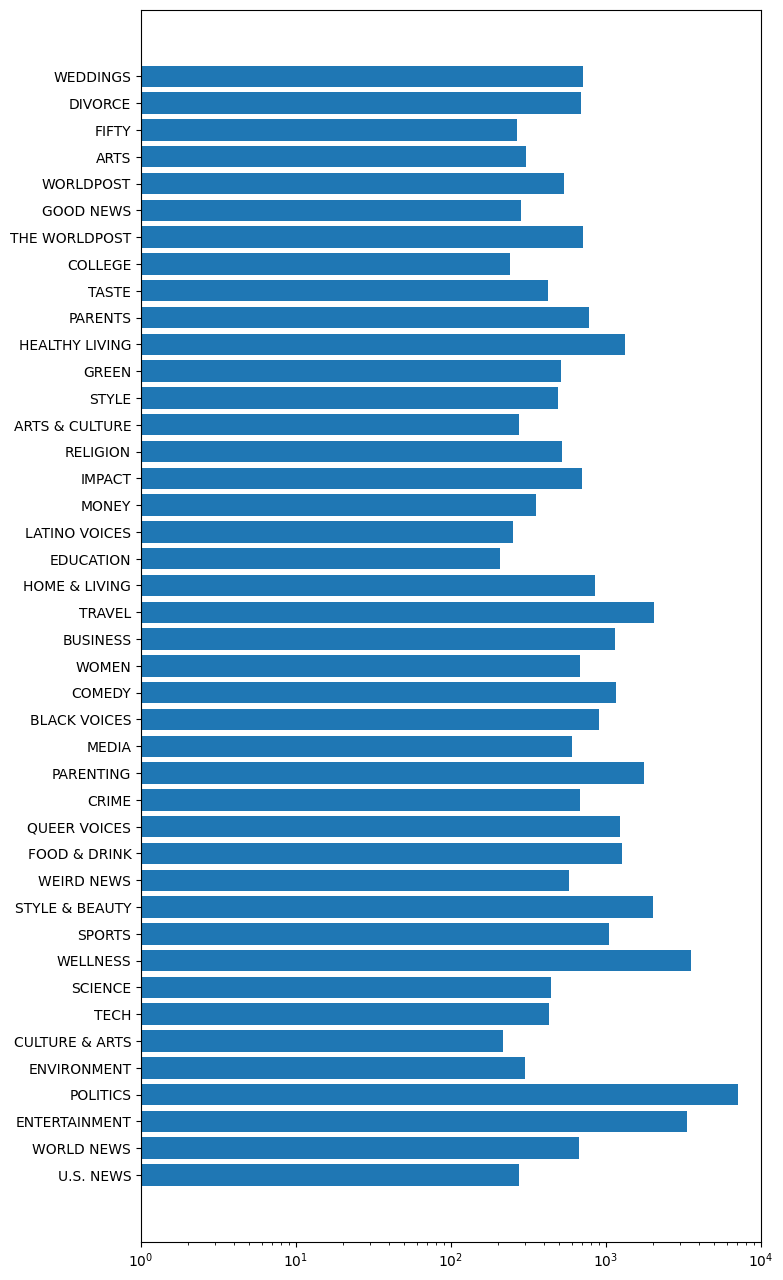

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 16))
plt.barh(range(len(label_count)), label_count.values())
plt.yticks(range(len(label_count)), label_count.keys())
plt.xscale('log')
plt.xlim([1, 10000])
plt.show()

Some labels are way more frequent than the others, note that we are using a logarithmic scale on the x-axis.

### Documents vectorisation

In order to cluster the documents, we need to first convert them into a vector format. We will use the `TfidfVectorizer` from Scikit-Learn to do this.

The `TfidfVectorizer` is very similar to the `CountVectorizer` we used in the text classification tutorial except that it multiplies the term frequency in the document by the inverse document frequecy of the term across the corpus: $\mathrm{tf}(t, d) \cdot \mathrm{idf}(t)$
- here $\mathrm{tf}(t, d)$ is the count of the term $t$ in the document $d$
- idf is inverse document frequency: $\mathrm{idf}(t) = \log{\frac{n + 1}{\mathrm{df}(t) + 1}} + 1$
- $n$ is the number of documents in collection
- and the document frequency, $\mathrm{df}(t)$ is the number of documents that contain the term $t$
- see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

The use of idf-weighting can be justified in term of information theory:
- the amount of **information** associated with a term quantifies the **amount of surprise** at seeing a term in a document
- the surprise decreases with its (prior) probability of occurrence and information must be additive, so we have:
  - $I(t) = \log{\frac{1}{P(t)}} = -\log{P(t)}$
- the probability of observing a particular term in a document is just the percentage of documents that contain the term:
  - $P(t) = \frac{\mathrm{df}(t)}{n}$
- We smooth this estimate so that small df(t) values don't cause unreasonably high idf values, we have:
  - $P(t) = \frac{\mathrm{df}(t)+1}{n+1}$
  - so $I(t) = \log{\frac{n+1}{\mathrm{df}(t)+1}}$
- The idf value used is then $\mathrm{idf}(t) = I(t) + 1$, where the $+1$ prevents idf from going to zero as df approaches $n$.


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

The vectorisation method takes a number of arguments that control the resulting vocabulary. We have set the following arguments:  
- **max_df = 0.8**: remove words occuring in more than half of the documents (note: this will get rid of any corpus-specific tags)
- **min_df = 5**: remove words occuring in less than 5 documents  
- **stop_words = 'english'**: remove stopwords using an english stopword list

We can now fit the vectorizer to the data:
- Note: we could transform the data at the same time, using the `fit_transform()` method, but we'll wait for now to transform the data

In [17]:
vectorizer.fit(documents)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

Let's have a quick look at the vocabulary. How big is it?

In [18]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 14424


Wow, that's quite big!

Let's print out a random sample of 100 terms from it to see what they look like:

In [19]:
import random

sorted(random.sample(vocab.tolist(),100))

['200',
 'acquaintances',
 'adrenaline',
 'apartments',
 'apes',
 'belts',
 'biased',
 'births',
 'borders',
 'bow',
 'bridge',
 'bullies',
 'cable',
 'californian',
 'carpet',
 'celebrating',
 'charges',
 'chinese',
 'colds',
 'commission',
 'compelled',
 'considering',
 'contracts',
 'coolest',
 'created',
 'cure',
 'decades',
 'demanding',
 'denim',
 'developments',
 'dolphin',
 'doubling',
 'downfall',
 'décor',
 'empire',
 'engineering',
 'enrique',
 'export',
 'expression',
 'famer',
 'favor',
 'fertile',
 'flower',
 'futuristic',
 'gotham',
 'guaranteed',
 'guitarist',
 'hacker',
 'harris',
 'helps',
 'holding',
 'hometown',
 'impromptu',
 'increase',
 'killed',
 'lorenzo',
 'louisiana',
 'loves',
 'manage',
 'manicure',
 'meteor',
 'mexico',
 'ordinary',
 'painter',
 'plunge',
 'proverbial',
 'quantum',
 'rewarding',
 'sabrina',
 'samantha',
 'sara',
 'shape',
 'sharing',
 'shepherd',
 'shorter',
 'shout',
 'slack',
 'sparkle',
 'spate',
 'specific',
 'stark',
 'sums',
 'sundan

Most of the terms look pretty good, but the representation looks reasonable.

Now let's vectorize the dataset:

In [20]:
vector_documents = vectorizer.transform(documents)

Here is the sparse vector for the first document:

In [21]:
print(vector_documents[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 17 stored elements and shape (1, 14424)>
  Coords	Values
  (0, 673)	0.1836683385965831
  (0, 3123)	0.23549916545189623
  (0, 3587)	0.24083663292153867
  (0, 4080)	0.3046239213114669
  (0, 4252)	0.20436026805292282
  (0, 4791)	0.2177712572262958
  (0, 4903)	0.19671690430108493
  (0, 6065)	0.16044467800073223
  (0, 8011)	0.2486148113370692
  (0, 8264)	0.37035178025964
  (0, 8719)	0.11741376175827647
  (0, 9075)	0.25746719558863806
  (0, 9910)	0.27044548833623877
  (0, 11084)	0.2544421462608796
  (0, 11233)	0.14355061944765263
  (0, 11925)	0.3169630456927109
  (0, 12866)	0.26149867697809726


The decimial values are the TF-IDF scores for the terms. We can sort the terms by their TF-IDF values, and print them out as follows:

In [22]:
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

[('million', 0.37035178025964),
 ('sleeves', 0.3169630456927109),
 ('doses', 0.3046239213114669),
 ('predict', 0.27044548833623877),
 ('targeted', 0.26149867697809726),
 ('ordered', 0.25746719558863806),
 ('roll', 0.2544421462608796),
 ('match', 0.2486148113370692),
 ('demand', 0.24083663292153867),
 ('covid', 0.23549916545189623),
 ('experts', 0.2177712572262958),
 ('early', 0.20436026805292282),
 ('fall', 0.19671690430108493),
 ('americans', 0.1836683385965831),
 ('health', 0.16044467800073223),
 ('said', 0.14355061944765263),
 ('new', 0.11741376175827647)]

Do the top terms agree with what you expected for the document?

Print it out below:

In [23]:
print(documents[0])

Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters

Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.


## Data exploration

Let's play a bit with our data

### Measuring the similarity between vectorised documents

The vectorizer also normalizes the resulting document representations such that their vectors have length one.
- We can see this by computing the dot-product between a vector representation and itself.
- For example, for the first document in the collection we have:

In [24]:
vec = vector_documents[0]
vec.multiply(vec).sum()

0.9999999999999998

To calculate the dot-product we multiplied the sparse vector by itself and then took the sum.

The fact that the vectors have length one (almost length of one due to approximations in the representation) means that the dot-product between vectors computes the cosine of the angle between them.
- The cosine of the angle between tf-idf vectors provides a value in the range [0,1], that is often used to measure the similarity between documents.
- Let's compute the similarity between the first two documents in the collection:

In [25]:
vector_documents[0].multiply(vector_documents[1]).sum()

0.019524138031446904

Here is the second document:

In [26]:
print(documents[1])

Cleaner Was Dead In Belk Bathroom For 4 Days Before Body Found: Police

The 63-year-old woman was seen working at the South Carolina store on Thursday. She was found dead Monday after her family reported her missing, authorities said.


The similarity value is zero, which isn't surprising since most documents don't share vocabulary.

The average vocabulary size of a document in the collection is:

In [27]:
nonzero_count = vector_documents.count_nonzero()
doc_count = vector_documents.get_shape()[0]

print(f"Average document vocabulary size: {nonzero_count/doc_count}")

Average document vocabulary size: 13.878322913186656


The first two documents came from different categories:

In [28]:
print(f"Category of 1st document: {labels[0]}")
print(f"Category of 2nd document: {labels[1]}")

Category of 1st document: U.S. NEWS
Category of 2nd document: U.S. NEWS


What if we compute the compute similarity between  documents from the same newsgroup? Let's see:

In [29]:
for i in range(1,200):
    if (labels[i] == labels[0]):
      print('Similarity:', vector_documents[0].multiply(vector_documents[i]).sum())


Similarity: 0.019524138031446904
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.024338565081018344
Similarity: 0.020693415810317008
Similarity: 0.010784543037625334
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.06437195189411839
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.10845854987367319
Similarity: 0.015377836352490813
Similarity: 0.09177816482830971
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.014039754494201563
Similarity: 0.12061545680232044
Similarity: 0.0
Similarity: 0.08069877506720793


Here documents are quite short, so it is hard to get a proper overlapping

### Searching the collection based on keywords

We could even use the same approach to compute the similarity between a search query and each of the documents in a collection in order to find the one that best matches with a query:

In [34]:
import numpy as np

# query = 'australia'
query = 'computer'
# query = 'covid'
# query = 'rock \'n roll'

query_vec = vectorizer.transform([query])[0]
#argmax gets the document with highest similarity
index = np.argmax([query_vec.multiply(vector_documents[i]).sum() for i in range(len(documents))])
print(documents[index])

The Computer's Next Conquest: Crosswords

What's a 10-letter word for smarty pants? This weekend the world may find out when computer technology again tries to best


That worked!
- Try some other queries.
- Does that reminds you of something we saw recently?
 - You could try implement the BM25 and try it on this data set https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables

## Clustering

Now we can start applying clustering to our vectorised documents

### Clustering with k-Means

Now that we have computed a vector representation, we can perform the clustering.

There are many different clustering algorithms in common use, from k-Means and Hierarchical clustering to DBScan and Spectral clustering.  
- Many of them are implemented in Scikit-learn: https://scikit-learn.org/stable/modules/clustering.html
- You can easily change the code below to try them out.

We will use the k-Means algorithm since it is very popular, fast, scalable and relatively robust.
- k-Means models the dataset using k circlular clusters
- where each cluster is represented by the centroid of the datapoints it contains.

To apply k-Means we need to decide in advance how many clusters to look for.
- We will set the number of clusters to be exactly the number of categories in the dataset to see if the clustering can recover the original groups from the data.

In [35]:
from sklearn.cluster import KMeans

k = len(set(labels))

kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_documents)

Initialization complete
Iteration 0, inertia 77219.96319131138.
Iteration 1, inertia 41078.899979868824.
Iteration 2, inertia 40828.04485165186.
Iteration 3, inertia 40706.60116055783.
Iteration 4, inertia 40651.408709777475.
Iteration 5, inertia 40609.26078603997.
Iteration 6, inertia 40567.781676981605.
Iteration 7, inertia 40534.05097160115.
Iteration 8, inertia 40505.95244626258.
Iteration 9, inertia 40489.67701906501.
Iteration 10, inertia 40484.14342922027.
Iteration 11, inertia 40481.129372406554.
Iteration 12, inertia 40477.397634125.
Iteration 13, inertia 40475.42473363049.
Iteration 14, inertia 40473.20113297199.
Iteration 15, inertia 40472.656619325775.
Iteration 16, inertia 40472.15012367604.
Iteration 17, inertia 40471.51400143356.
Iteration 18, inertia 40470.620864710865.
Iteration 19, inertia 40470.36258456003.
Iteration 20, inertia 40470.30588842214.
Iteration 21, inertia 40470.21822787181.
Iteration 22, inertia 40469.91675897535.
Iteration 23, inertia 40469.55565564885

KMeans(max_iter=100, n_clusters=42, n_init=2, random_state=2307, verbose=True)

The inertia values are actually the *sum of squared distances between each sample to its closest cluster centroid*
- This is the measure that k-Means seeks to minimise
- Note: It is not the cosine distance between document and the cluster center (which is what we would like to minimise), but given that each vector has length one, the squared Euclidean distance is similar to it.  



### Clustering evaluation

Once we have run our clustering algorithm, we can

#### Investigating the Clusters

The clustering routine has now produced clusters in a very high dimensional feature space (with tens of thousands of dimansions).
- We can't plot such high dimensional data to see whether the clusters look coherent or not.
- Instead we will need to investigate the coherency of the clusters by looking at the terms occuring in them.

We can see the important terms for each cluster by inspecting the centroid vector for the cluster.
- Let's have a look at the terms with high weights in the centroid of the first cluster:

In [36]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[vocab[j] for j in sorted_terms[:20]]

['check',
 'facebook',
 'pinterest',
 'twitter',
 'huffpost',
 'tumblr',
 'sure',
 'style',
 'want',
 'instagram',
 'huffpoststyle',
 'photos',
 'touch',
 'weddings',
 'stylelist',
 'home',
 'photo',
 'divorce',
 'say',
 'video']

The top 10 terms look pretty consistent to me. What do you think?
- Note that the k-Means algorithm makes use of random initialisations,
- so every time we run it, we will get a different assignment of cluster IDs to the clusters
- (although the clusters themselves should remain relatively stable).

We could use our dot-product search trick from before to find the document in the collection that is the best exemplar of the cluster:

In [37]:
index = np.argmax([np.dot(centroid,vec) for vec in vector_documents.toarray()])

print(documents[index])

Aerie Model: 'I Do Like To See A Little Retouching On Myself'

Want more? Be sure to check out HuffPost Style on Twitter, Facebook, Tumblr, Pinterest and Instagram at @HuffPostStyle. At


We now know what terms were important for defining cluster 0 and have seen a representative document,
- but still don't know how many documents were assigned to to the cluster.
- Let's find out:

In [38]:
sum(kmeans.labels_ == 0)

262

We can see which clusters the first 10 documents have been assigned to:

In [39]:
for i in range(10):
    print(f"document {i} is in cluster {kmeans.labels_[i]}")

document 0 is in cluster 22
document 1 is in cluster 29
document 2 is in cluster 10
document 3 is in cluster 31
document 4 is in cluster 25
document 5 is in cluster 2
document 6 is in cluster 3
document 7 is in cluster 36
document 8 is in cluster 2
document 9 is in cluster 39


Let's now repeat the process (algorithmically) to get the top terms for all the clusters.
- In the code below, we iterate over the clusters, getting the centroid for each, sort the values and printing out the top terms:

In [42]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['check', 'facebook', 'pinterest', 'twitter', 'huffpost', 'tumblr', 'sure', 'style', 'want', 'instagram']
Cluster 1:	['clinton', 'hillary', 'trump', 'sanders', 'donald', 'bernie', 'campaign', 'democratic', 'election', 'vote']
Cluster 2:	['just', 'like', 'time', 'world', 'video', 'years', 'know', 'don', 'way', 'says']
Cluster 3:	['heart', 'disease', 'risk', 'health', 'like', 'study', 'attack', 'mind', 'love', 'good']
Cluster 4:	['work', 'hard', 'day', 'time', 'home', 'make', 'job', 'ways', 'just', 've']
Cluster 5:	['taking', 'place', 'time', 'just', 'world', 'like', 'way', 've', 'care', 'video']
Cluster 6:	['law', 'enforcement', 'federal', 'anti', 'state', 'voter', 'id', 'new', 'judge', 'court']
Cluster 7:	['week', 'fashion', 'funniest', 'tweets', 'photos', 'new', 'york', 'best', 'news', 'women']
Cluster 8:	['party', 'sexual', 'assault', 'harassment', 'allegations', 'democratic', 'misconduct', 'republican', 'accused', 'abuse']
Cluster 9:	['love', 'life'

That's interesting.
- It looks like each of the clusters contains relatively consistent terms.

How many documents have been assigned to each cluster?

In [43]:
print('Number of docs in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of docs in: 
Cluster 0: 262
Cluster 1: 442
Cluster 2: 15627
Cluster 3: 301
Cluster 4: 588
Cluster 5: 413
Cluster 6: 261
Cluster 7: 613
Cluster 8: 448
Cluster 9: 764
Cluster 10: 650
Cluster 11: 279
Cluster 12: 177
Cluster 13: 1344
Cluster 14: 659
Cluster 15: 388
Cluster 16: 254
Cluster 17: 344
Cluster 18: 706
Cluster 19: 801
Cluster 20: 550
Cluster 21: 347
Cluster 22: 879
Cluster 23: 1115
Cluster 24: 1318
Cluster 25: 704
Cluster 26: 405
Cluster 27: 466
Cluster 28: 512
Cluster 29: 655
Cluster 30: 958
Cluster 31: 1058
Cluster 32: 933
Cluster 33: 354
Cluster 34: 571
Cluster 35: 956
Cluster 36: 487
Cluster 37: 1634
Cluster 38: 255
Cluster 39: 1661
Cluster 40: 394
Cluster 41: 373


Looks like there is a very large cluster corresponding to terms that might be more common across the corpus. Mostly, though, the counts are pretty well distributed across the clusters.

#### Quantitative Evaluation of Clustering Results

Let's now move on to the task of quantitatively evaluating the clustering algorithm. There are two ways to evaluate the results of a clustering algorithm:
- **Intrinsic evaluation** - If the ground truth is not known, you could use:
    - Within-cluster sum-of-squares: that is the *inertia* of the K-Means clustering
    - [Silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) - "a higher Silhouette Coefficient score relates to a model with better defined clusters"
**Extrinsic evaluation** - If the ground truth is known (as in this case, since we have the categories) we can compute:
    - [Homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)
    - [Completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)
    - [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score)

Let's first have a look at the *intrinsic measures*
- print out within-cluster sum-of-squares and the silhouette coefficient:


There are many possible metrics for clustering evaluation: some can be used when the ground truth labels are known, some can be used when the true labels are unknown.



In [44]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 40459.27166789903
Silhouette coefficient: 0.007649269440070319


The intrinsic evaluation measures are hard to interpret, since their values depend heavily on the difficulty of the clustering task, the amount of data, etc.
- Moreover, the sum-of-squares value will improve monotonically as the number of clusters is increased.

Extrinsic evaluation measures:
- in this case we compare the labels assigned to the documents by the clustering algorithm with the ground truth assignments (newsgroups).
- Since the clusters found could be (i) fewer or more than the number of classes, and (ii) won't be ordered the same as the labels,
- a process of aligning the labels and clusters is performed internally for each of these metrics.

In [45]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(labels, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(labels, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(labels, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(labels, kmeans.labels_)))

Extrinsic evaluation measures:
Homogeneity: 0.1176188320283577
Completeness: 0.13372159295714323
V-measure: 0.1251543804105365
Adjusted Rand-Index: 0.0003885105617839657


### Minibatch K-means clustering

MiniBatch k-Means is an approximate verions of the k-Means that is designed to scale up to massive datasets by making use of small samples (minibatches) in order to find the k centroids.
- It should be faster to run than k-Means. Let's give it a try:

In [46]:
from sklearn.cluster import MiniBatchKMeans

k = len(set(labels))

mb_kmeans = MiniBatchKMeans(n_clusters=k,batch_size=500, random_state=2307)
mb_kmeans.fit(vector_documents)

MiniBatchKMeans(batch_size=500, n_clusters=42, random_state=2307)

Evaluate the minibatch clustering algorithm to see if the performance compares with the original k-Means on this data:

In [47]:
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(mb_kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, mb_kmeans.labels_)))
print("\n")
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(labels, mb_kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(labels, mb_kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(labels, mb_kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(labels, mb_kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 41360.4797062336
Silhouette coefficient: -0.026219118527566018


Extrinsic evaluation measures:
Homogeneity: 0.03457372380854976
Completeness: 0.13896025697021588
V-measure: 0.05537098294285461
Adjusted Rand-Index: -0.009897358544592949


### Selecting a value for k

When used on low dimensional data, k-Means is often combined with the 'elbow method' (https://en.wikipedia.org/wiki/Elbow_method_(clustering)) for finding the 'right' number of clusters k

The method involves:
- running the clustering algorithm with increasing values of *k*
- plotting the intrinsic evaluation measure (within-cluster sum-of-squares)
- and looking for a point in which improvement in the measure decreases substantially from one time step to the next.

Let's try out the method using the MiniBatch version of k-Means since it is a bit faster to run.
- First generate the performance evaluation measure values across the range of k values:

In [48]:
performance = [MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=2307).fit(vector_documents).inertia_ for k in range(1,50)]
performance

[41717.65451103597,
 41716.652342214016,
 41664.91633099426,
 41601.70708156111,
 41551.847180790115,
 41443.687196224506,
 41405.56639416465,
 41383.958164263,
 41337.81691909737,
 41304.95212575115,
 41305.984951208775,
 41293.70659171797,
 41295.99586899886,
 41308.96006459427,
 41271.29400112616,
 41336.121699397074,
 41266.75475686081,
 41224.81460886376,
 41158.79843347962,
 41250.912547837615,
 41289.539350544896,
 41329.55061831937,
 41252.60685277645,
 41396.21494527256,
 41352.32559831814,
 41348.93309906078,
 41367.37187784379,
 41367.613065526435,
 41363.08308124425,
 41327.14776478647,
 41408.76981251861,
 41418.62609785487,
 41411.67924101914,
 41426.896960811464,
 41392.04736662814,
 41404.70526296525,
 41374.1586619075,
 41374.52847384955,
 41332.17672848751,
 41369.43731219379,
 41332.45944545801,
 41360.4797062336,
 41368.189802273955,
 41395.417693901356,
 41418.769190714986,
 41423.90804974322,
 41383.37755062619,
 41420.040142861006,
 41419.10061748365]

Note that the within-cluster sum-of-squares almost always improves from one iteration to the next as k is increased.
- In theory it should always increase since the more cluster centroids there are, the more flexibility the model has for describing datapoints (assigning them to clusters)
- but in practice the stochasticity of k-Means and also the mini-batch procedure can cause the algorithm to not find the global optimum and thus produce a higher sum-of-squares value than a previous iteration (with lower k).

We'll now use some standard code to plot the performance measure against the value k:

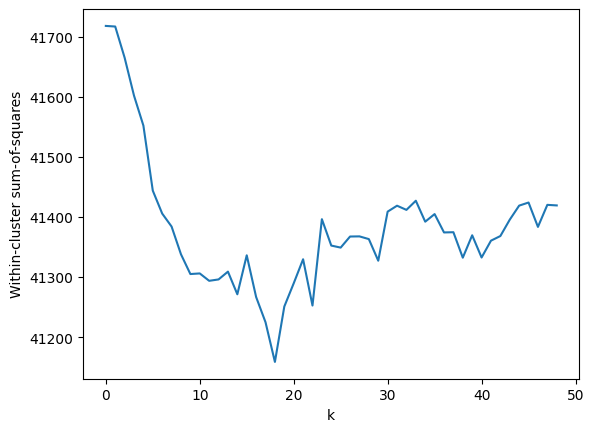

In [49]:
plt.figure()
plt.plot(performance)
plt.ylabel('Within-cluster sum-of-squares')
plt.xlabel('k')
plt.show()

Does it look to you like there is a point on the graph where performance suddenly stops getting a lot better?
- I don't see one ...
- That is likely because we have (i) very high dimensional data and (ii) quite a large number of documents.

## Visualisation

Often visualisng the samples and the model output is useful to understand what's going on

### Problems visualising high dimensional data

For a bit of fun, we'll try to transform the high dimensional data into low dimensional data (just 3 dimensions) using a linear dimensionality reduction technique called Singular Value Decomposition.
- We'll transform the `vector_documents` to be 3 dimensional.

In [50]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)
[x,y,z]

[array([0.08277585, 0.10164919, 0.09308692, ..., 0.03411782, 0.04983779,
        0.01847883]),
 array([-0.01877422, -0.04142961, -0.03787443, ..., -0.0164509 ,
         0.00633988, -0.00408293]),
 array([-0.03834842, -0.05113648,  0.04385713, ..., -0.01166402,
        -0.0121035 , -0.00441014])]

Now that we have the data in the right form, let's plot it with colours determined by the category it comes from to see if we can see structure in the data.

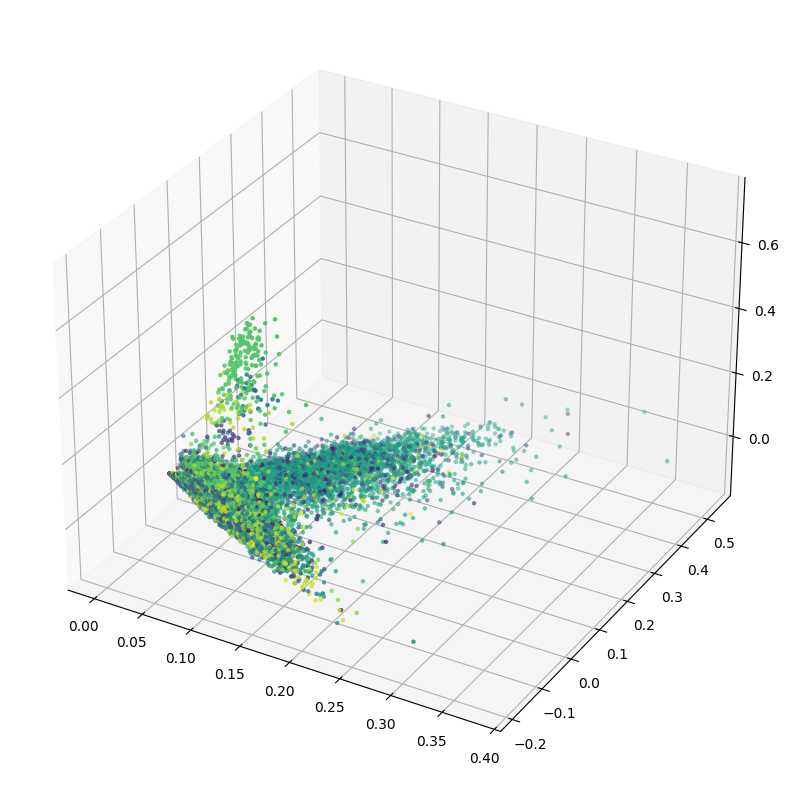

In [51]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(labels), marker='.');

Can you see some structure in there?

We can plot the same data coloured according to the clusters found by the original k-Means algorithm:

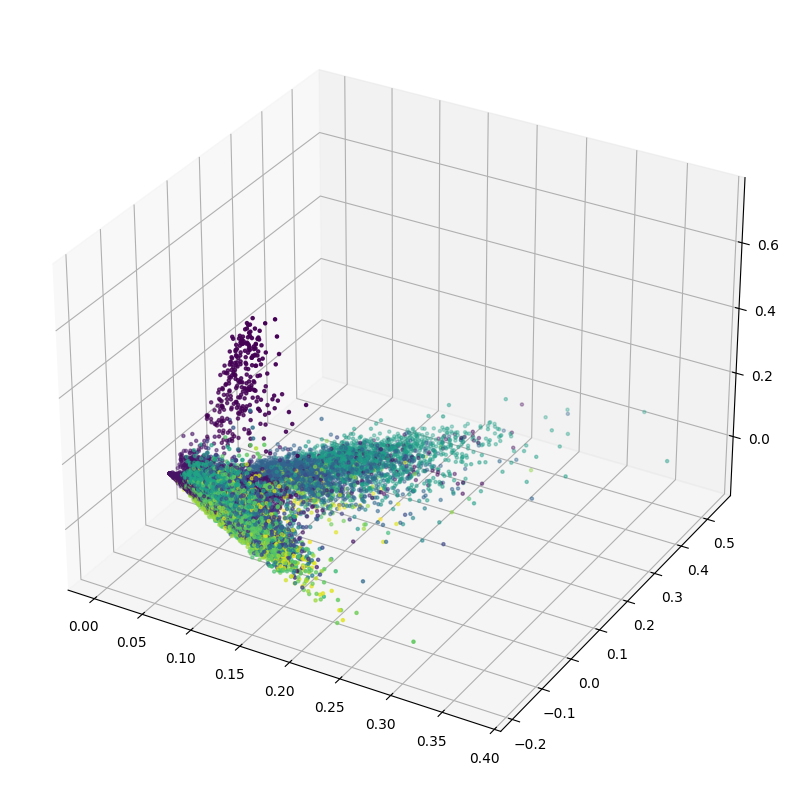

In [52]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=kmeans.labels_, marker='.');

Do you think the clustering algorithm working correclty according to this visualisation?

## Topic Models

We now investigate a different type of clustering of documents called Topic Modeling.
- Unlike k-Means clustering where the cluster assignment are exclusive and each document can belong to one cluster only, in Topic Modeling each document belongs to many clusters at the same time.
- Each document is represented as a mixture of those clusters (refered to as topics).
- The most famous topic modeling technique is an algorithm called Latent Dirichlet Allocation (LDA)

To learn a topic model, we'll use the sklearn implementation of LDA and apply it to the same headline categories data that we used above.
- This time though, we'll load the data into two subsets: a training set and a test set.
- LDA learns a low dimensional representation of the documents. We will learn the LDA model on the training data only, so that later we can demonstrate how to transform new documents into the same document representation.
- We will also used a slightly cleaner version of the newsgroup data this time by removing 'headers', 'footers' and quoted messages.

In [53]:
from sklearn.model_selection import train_test_split

documents_train, documents_test, label_train, label_test = train_test_split(documents, labels, test_size=0.4)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

No. training docs: 25143
No. testing docs: 16763


We make use of the `CountVectorizer` rather than the TfidfVectorizer, since LDA is a probabilistic model for explaining term counts and thus expects counts rather than weights.
- Let's set the `CountVectorizer` to remove stopwords and use the same the max/min document frequency settings as we had for k-Means clustering.
- We'll use the `fit_transform()` method of the vectorizer to both fit the vocabulary and transform the data to the vector representation at the same time (performing both steps at once is a little more efficient than doing them separately).

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(documents_train)

The vocabulary size is slightly smaller than before:

In [55]:
vocab = vectorizer.get_feature_names_out()
len(vocab)

10675

### Extracting topics using Latent Dirichlet Allocation (LDA)

Now we'll fit an LDA topic model to the dataset.
- Just like with k-Means where we needed to choose the number of clusters
- with topic models we need (usually) to choose the number of topics to use to represent each document.
- It's common to choose values up to 1000 for the number of topics.

For the scope of this tutorual, we'll set the number of topics to just 30 (you can try larger values later):
- Note that fiting the model will take a few minutes.
- We use the 'online' learning method since there may be a bug in the 'batch' method: https://github.com/scikit-learn/scikit-learn/issues/6777

In [56]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30, verbose=1)

Once the model is learnt, we could measure the performance of the model in terms of its perplexity:
- Perplexity measues how confused/surprise a model is at seeing new data, and is a commonly used measure of the prediction performance of a language model.
- It computes the average number of bits required to encode the test data using the model. (Equivalently, it can be seen as 2 raised to the power of the cross-entropy. See: https://en.wikipedia.org/wiki/Perplexity)
- We'll use the test dataset as the new data here, so we'll first need to vectorize it before computing the perplexity:

In [57]:
vector_documents_test = vectorizer.transform(documents_test)
lda.perplexity(vector_documents_test)

12079.932364549837

Let's now have a look at the topics found:
- As we did for k-Means, we'll print out the 10 most important terms for each topic
- The code below looks a little more complicated than it is:
  - The for loop iterates over each topic in turn, sorting the terms for the topic from most important to least,
  - it then grabs the vocabulary term for tht top 10 and concatenates them together before printing them out.

In [58]:
import numpy as np

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [day, kids, today, study, million, sleep, month, according, weekend, just]
Topic 2:	 [gun, hope, having, 2014, control, save, sense, middle, science, gives]
Topic 3:	 [watch, video, really, american, healthy, anti, new, food, people, said]
Topic 4:	 [president, bad, small, fear, true, crisis, likely, team, nearly, talking]
Topic 5:	 [love, great, child, police, baby, best, water, 20, world, russia]
Topic 6:	 [know, week, women, news, men, season, travel, hard, mother, don]
Topic 7:	 [look, death, rights, john, kind, justice, person, department, town, died]
Topic 8:	 [house, gop, court, said, years, republicans, dead, sexual, senate, aren]
Topic 9:	 [right, help, says, little, better, days, story, way, morning, home]
Topic 10:	 [list, favorite, government, global, latest, killed, drug, reveals, email, director]
Topic 11:	 [good, school, feel, state, clinton, woman, face, hillary, summer, girl]
Topic 12:	 [photo, war, game, different, daughter, son, taking, fight, michael, nati

What do you think about the quality of the topics?
- Do they look coherent to you?
- Note that the topic model doesn't make any use of the characters in the words, so 'gun' and 'guns' are related only because they occur in similar contexts.

We could visualise the prevalence of the words in each topics using some code adapted from:
- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
- Note that the code at the link above also compares LDA with Non-negative Matrix Factorization (NMF) applied to tf-idf matrices, which is an alternative non-probabilistic approach to developing topic models with comparable performance.

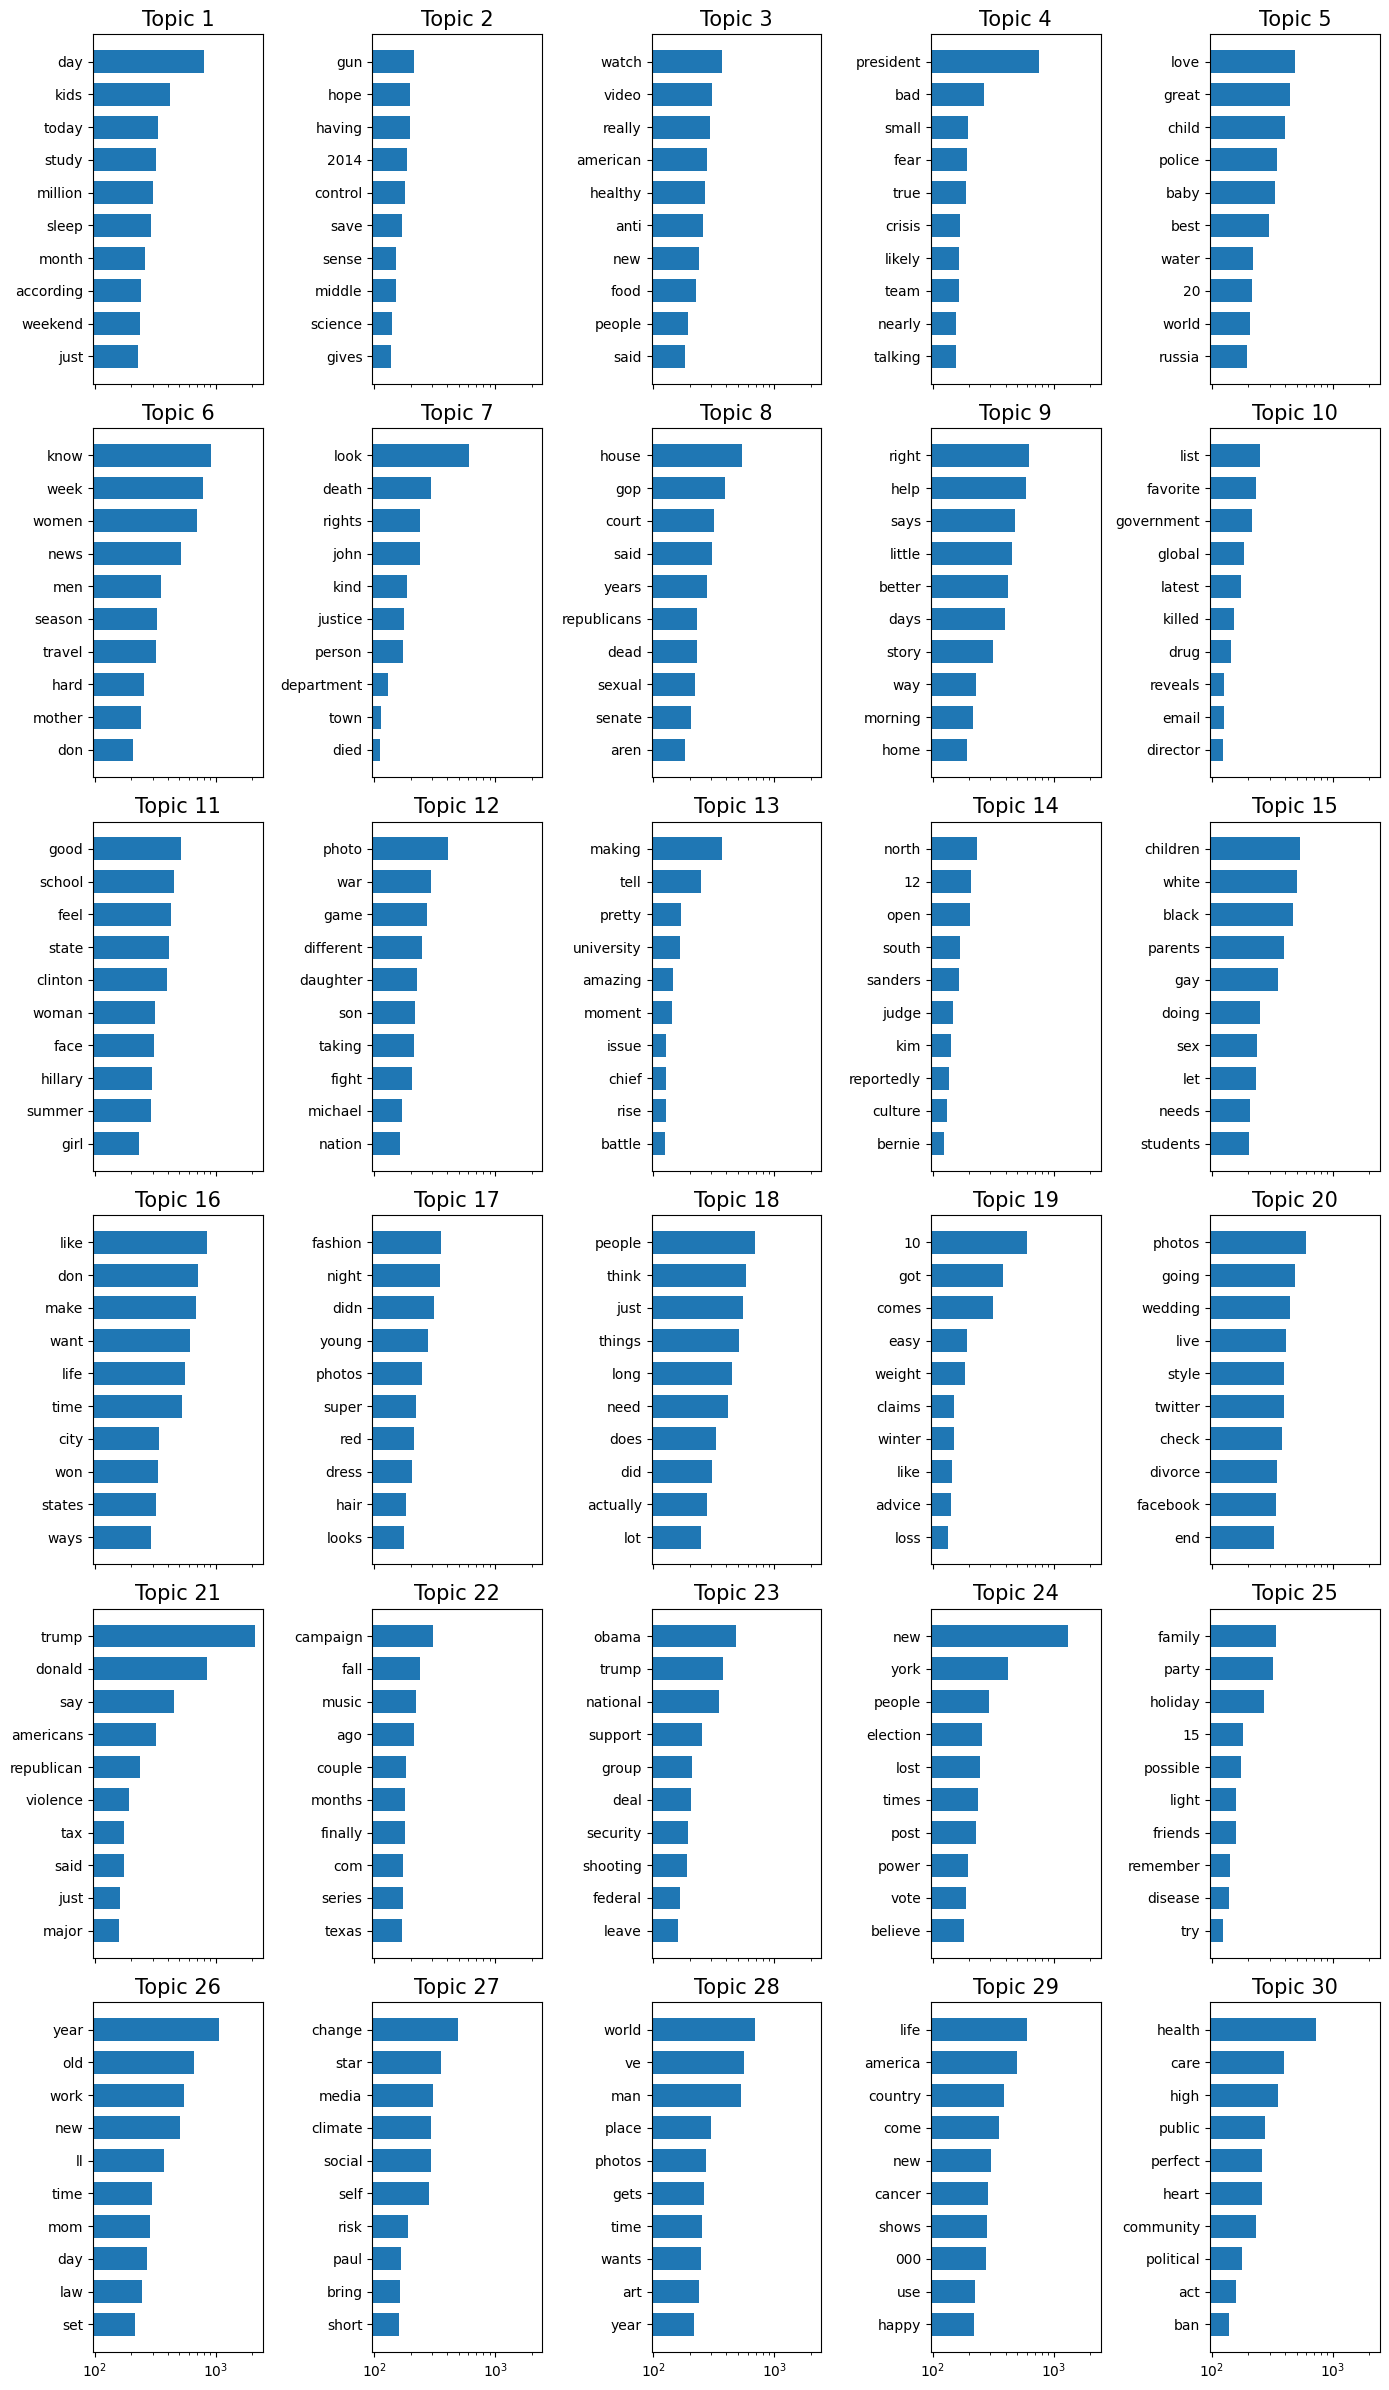

In [59]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

### Investigating the topic description for a single document

The interesting aspect of topic modeling with respect to normal document clustering is that each document is represented by a vector of topics, rather than a single cluster. Thus the topic representation can be useful for:
- describing the document content, and
- calculating similarities/distances between documents that takes synonymy (different term, same meaning) and polysemy (same term, different meaning) into account.

Let's have a look at that description for a particular document:
- To make things more interesting, we'll select the document from the test set that wasn't used to train the LDA model.
- We'll take the first example:

In [61]:
doc = documents_train[6033]
print(doc)

Palestinian Refugees: Employment Is the Solution

Palestinian refugees need employment more than handouts. Calling for support, not only through donations, but through livelihood, is crucial. Only a sustainable aid model will empower those with no rights.


Now to see its topic vector we need to vectorize and then transform (using LDA) the document to the topic space:

In [62]:
doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]
topic_vec

array([0.12804346, 0.00185185, 0.00185185, 0.00185185, 0.00185185,
       0.00185185, 0.05740741, 0.00185185, 0.16851852, 0.05740741,
       0.00185185, 0.00185185, 0.00185185, 0.11296296, 0.00185185,
       0.15343802, 0.00185185, 0.00185185, 0.00185185, 0.00185185,
       0.00185185, 0.00185185, 0.05740741, 0.00185185, 0.11296296,
       0.05740741, 0.00185185, 0.00185185, 0.05740741, 0.00185185])

Well there we have it: the topic vector representation of the document above.
- Notice that many topics have the same small same value associated with them.
- That just means that no words from that topic were found in the document. (A topic model is a generative statistical model, so it can't allow probabilities to actually be zero.)

Let's now generate a more interpretable representation of the document by
- getting rid of the low frequency topics (less than 1% prevalence) and
- listing the common words for the topic.

To do this, first sort the topics from most important to least (both the index and the value):

In [63]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

Now iterate over the top 10 topics, disregarding those with frequency less than 1%, and print out the prevelance and the top terms for each:

In [64]:
for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

16.9% Topic 8: right help says little better days story way morning home
15.3% Topic 15: like don make want life time city won states ways
12.8% Topic 0: day kids today study million sleep month according weekend just
11.3% Topic 13: north 12 open south sanders judge kim reportedly culture bernie
11.3% Topic 24: family party holiday 15 possible light friends remember disease try
5.7% Topic 6: look death rights john kind justice person department town died
5.7% Topic 22: obama trump national support group deal security shooting federal leave
5.7% Topic 9: list favorite government global latest killed drug reveals email director
5.7% Topic 25: year old work new ll time mom day law set
5.7% Topic 28: life america country come new cancer shows 000 use happy


What do you think? Is it a good description?
- Do the set of topics agree with the content of the document?

### Visualising Topic Representations of Documents with t-SNE

We tried to visualise the extremely high dimensional tfidf bag-of-words data in the last session using Singular Value Decomposition (SVD) and it didn't work very well at all.
- The dimension of the data is MUCH smaller now, since there are very few topics (30) compared to the size of the vocabulary (\~10,000).
- Thus it should be much easier to find a 3 dimensional represenation of the data.

This time we'll use a different dimensionality reduction technique called t-SNE:
- t-SNE stands for t-distributed Stochastic Neighbor Embedding.
- It is a non-linear technique that, unlike SVD, acts to preserve the relative distances between *nearby objects* (similar documents in the original space) when building the mapping.
- (SVD is a linear technique that acts instead to preserve relative distances between the most distant objects in the space.)

We'll run t-SNE on the test data set that wasn't used to estimate the LDA model, and create an 3-dimensional embedding from the high-dimensional data:

In [65]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

(16763, 3)

Convert the data to the (x,y,z) format needed for plotting:

In [66]:
[x, y, z] = np.transpose(tsne_embedding)

And plot it in a 3d scatter plot with the ground-truth newsgroup labels used to colour the datapoints:
- Note: If you are using Jupyter Notebook rather than Google Colab to run this notebook, you can uncomment the first line ('%matplotlib notebook') below to make the 3d plot interactive. Don't do that if you are using colab as it will prevent you form seeing the plot.

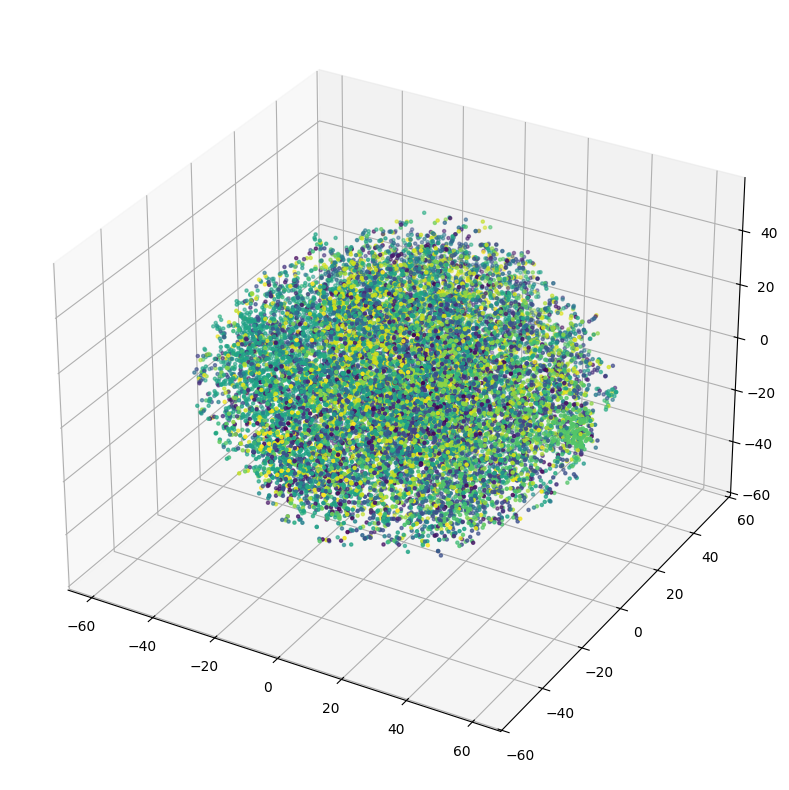

In [67]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(label_test), marker='.');

Seems like there might be a little more structure there than last time, but still quite hard to tell.

Instead of colouring based on the newsgroups, we can assign each document to its most frequent topic and colour based on the topic:

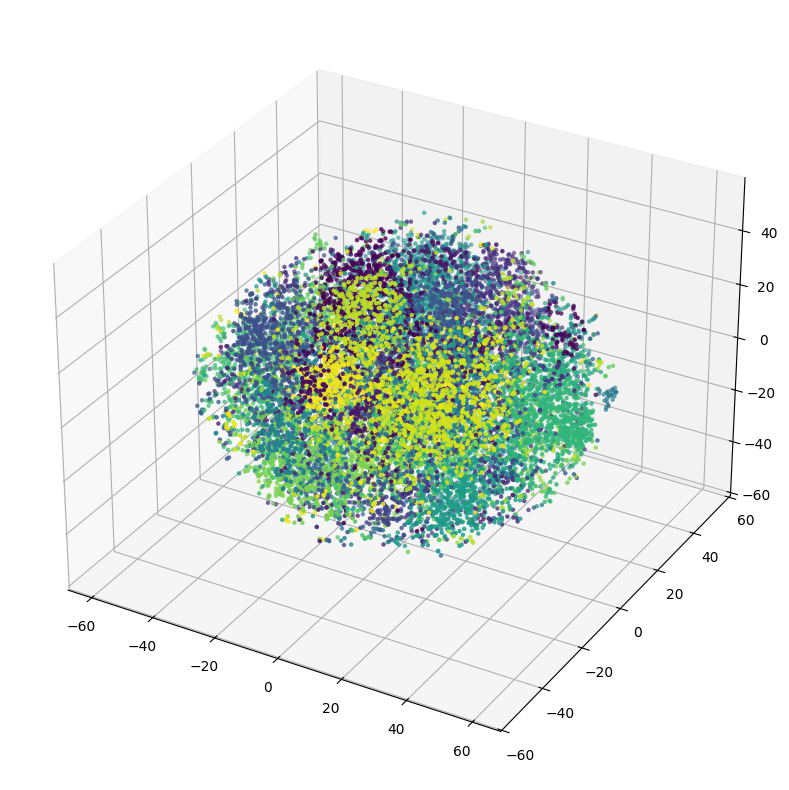

In [68]:
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=freq_topic, marker='.');

What if we want to see it in 2D?

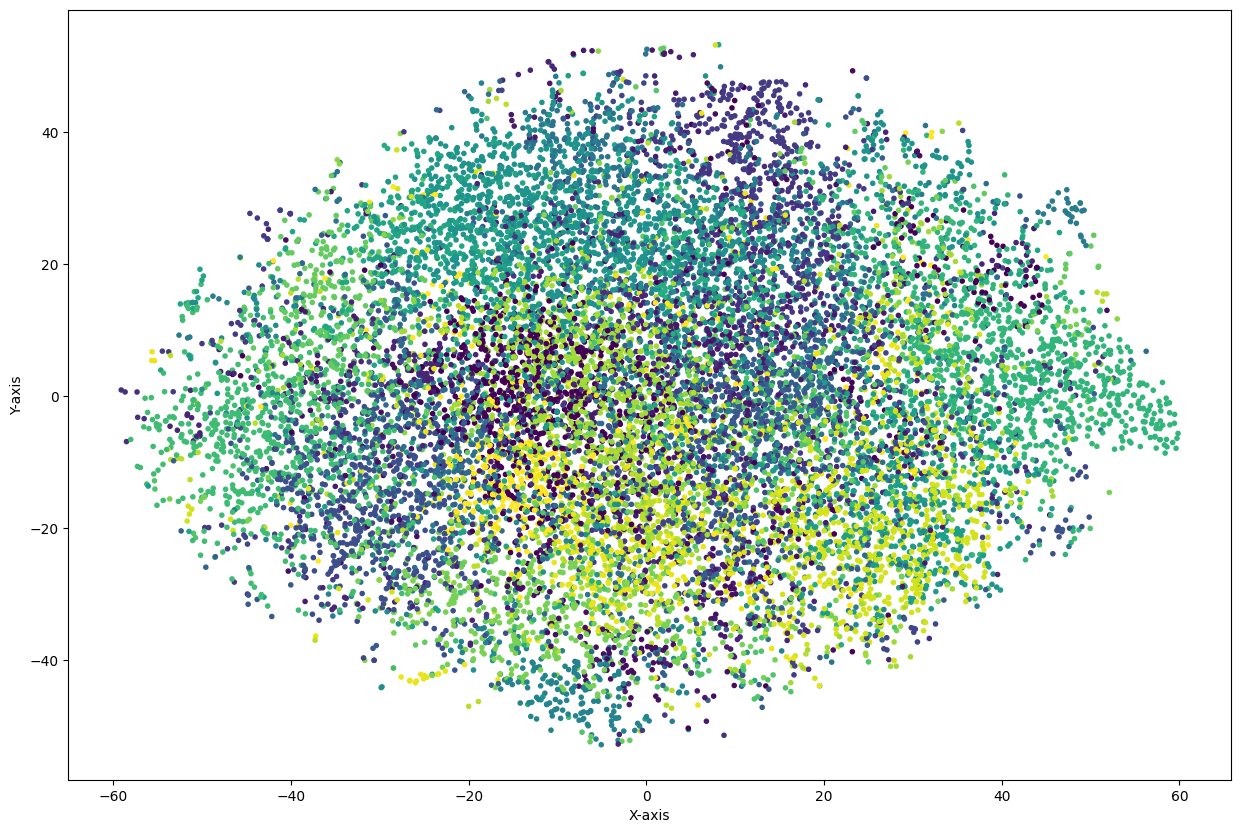

In [78]:
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x, y, c=freq_topic, cmap='viridis', marker='.')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
plt.show()